# Coronavirus Tweets: Case Study of the Lockdown

### Read In & Clean Text

In [1]:
# Read in, clean, and vectorize data
import pandas as pd
import numpy as np
import random 
import os
import glob
import re
import string

In [2]:
# plot setting
pd.set_option("display.max_colwidth", 400) 
from matplotlib import pyplot as plt
import seaborn as sns
sns.set(rc={'figure.figsize':(14,10)})

# ingnore warnings
import warnings
warnings.filterwarnings('ignore')

In [3]:
# notebook setting
from IPython.core.display import HTML
css = open('style-table.css').read() + open('style-notebook.css').read()
HTML('<style>{}</style>'.format(css))

In [4]:
# Importing spaCy natural learning processing library
import spacy
import en_core_web_sm
nlp = en_core_web_sm.load(disable=['parser', 'ner'])

# Importing scikit-learn modules
from sklearn.feature_extraction.text import TfidfVectorizer

### Prepping the Data

In [5]:
os.getcwd()

'C:\\Users\\kre8tions\\Documents\\The-Lab\\Capstone 2 Project\\Coronavirus Tweets\\Notebook'

In [6]:
os.chdir('..')

In [7]:
os.chdir('Data\Processed')

In [8]:
trunc_df = pd.read_csv('trunc_df.csv')
trunc_df

,user_id,created_at,screen_name,text,is_quote,is_retweet,favourites_count,retweet_count,followers_count,friends_count,account_created_at,account_age
0,5120691,2020-04-09 06:00:19+00:00,wef,How to stay creative and keep your family sane during lockdown – from one of the world’s best teachers @Andriazaf https://t.co/33BiAZ4kyO #coronavirus https://t.co/Xj1brpTsqt,False,False,1784,55,3713010,489,2007-04-18 14:00:19+00:00,4729
1,13813962,2020-04-29 02:22:02+00:00,afigueiredo,“Hosts are calling it the Airbnb apocalypse. But it’s more akin to an enema”\n\n#travel #COVID19 \nIs this the end of Airbnb? https://t.co/LiVQghInTQ https://t.co/IL64hUMwmI,False,False,7683,0,17112,13892,2008-02-22 10:54:21+00:00,4419
2,1223962854,2020-04-28 16:10:53+00:00,SwedeninMumbai,#Safety &amp; #Health is essential during #Covid19 specially for frontline workers &amp; thats what #SafetyDay2020 is about. Sweden fasttracked the process of accessing #PPE for health &amp; essential services through @RISEsweden. Swedish companies are manufacturing PPEs &amp; protective gear https://t.co/aR80B9jWwm,True,False,699,0,2038,403,2013-02-27 08:45:32+00:00,2587
3,814140012,2020-04-13 14:14:32+00:00,MoodyFooka1,"Sailor on USS Roosevelt, whose captain was fired after pleading for help, dies of #coronavirus #CoronaVirusUpdate\n#Covid19 #SailorDies\n\nhttps://t.co/UlGrjQM9KA via ⁦@USATODAY⁩",False,False,12648,3,5381,5907,2012-09-10 00:21:49+00:00,2757
4,402727770,2020-04-18 21:28:40+00:00,BeckiLouisexo,I feel like normal is very far away! #Covid19,False,False,1979,0,73,157,2011-11-01 13:57:33+00:00,3071
...,...,...,...,...,...,...,...,...,...,...,...,...
109252,3297577034,2020-04-02 11:58:29+00:00,SyedNasirHShah,SindhGovt has started anti septic fumigation to protect citizens amid the spread of #COVID_19 and aims to disinfect all the districts across the province. May Allah protect every one Ameen. Stay home to save lives.,False,False,7905,72,66339,438,2015-07-27 12:21:15+00:00,1707
109253,196062285,2020-04-21 11:18:25+00:00,TheKillidGroup,U.S. Top Commander Seeks Reduction in Hostilities to Curb Spread of Coronavirus in Afghanistan\nhttps://t.co/VdC2CPQJGb\n#NATO\n#Afghanistan\n#COVID19\n#ReductionInViolence https://t.co/bmQXM9w0X1,False,False,1212,0,9234,123,2010-09-28 07:00:05+00:00,3470
109254,20849049,2020-04-06 19:21:57+00:00,phillipnorton,"Deeply worrying. @BorisJohnson in intensive care. Whatever your politics, whatever gripes you may have, he was leading us all through this. Wishing the Prime Minister well #COVID19 #coronavirus https://t.co/5Ldn6QIgVI",True,False,3808,1,3893,1245,2009-02-14 14:21:04+00:00,4061
109255,6506032,2020-04-01 03:12:32+00:00,HoustonBen,If only there was a person in gov that cld turn hopes into reality. If only there were ppl that cld represent us &amp; make rules 4 the good of the everyone. It is MY HOPE that we would have leaders that would know their job is to be more than just a cheerleader. #coronavirus https://t.co/7DGUwJsfvP,True,False,409,0,602,548,2007-06-01 17:36:21+00:00,4685


In [9]:
trunc_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 109257 entries, 0 to 109256
Data columns (total 12 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   user_id             109257 non-null  int64 
 1   created_at          109257 non-null  object
 2   screen_name         109257 non-null  object
 3   text                109257 non-null  object
 4   is_quote            109257 non-null  bool  
 5   is_retweet          109257 non-null  bool  
 6   favourites_count    109257 non-null  int64 
 7   retweet_count       109257 non-null  int64 
 8   followers_count     109257 non-null  int64 
 9   friends_count       109257 non-null  int64 
 10  account_created_at  109257 non-null  object
 11  account_age         109257 non-null  int64 
dtypes: bool(2), int64(6), object(4)
memory usage: 8.5+ MB


### Clean, lemmanize, tokenize our text

In [9]:
# Tokenizing our text to start 
from spacy.lang.en.stop_words import STOP_WORDS
punctuations = string.punctuation
stopwords = list(STOP_WORDS)

parser = en_core_web_sm.load(disable=["tagger", "ner"])
parser.max_length = 500000

def spacy_tokenizer(sentence):
    mytokens = parser(sentence)
    mytokens = [ word.lemma_.lower().strip() if word.lemma_ != "-PRON-" else word.lower_ for word in mytokens ]
    mytokens = [ word for word in mytokens if word not in stopwords and word not in punctuations ]
    mytokens = " ".join([i for i in mytokens])
    return mytokens


In [10]:
from tqdm import tqdm


In [11]:
tqdm.pandas()
trunc_df["processed_text"] = trunc_df["text"].progress_apply(spacy_tokenizer)

C:\Users\kre8tions\anaconda3\lib\site-packages\tqdm\std.py:703: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel
100%|██████████| 109257/109257 [10:32<00:00, 172.79it/s]


### Vectorize our processed text

In [12]:
# Vectorizing text with scikit-learn TfidfVectorizer
def vectorize(text, features):
    
    vectorizer = TfidfVectorizer(max_features=features)
    X = vectorizer.fit_transform(text)
    return X

In [13]:
text = trunc_df['processed_text'].values
X = vectorize(text, 2 ** 11)
X.shape

(109257, 2048)

In [14]:
from sklearn.decomposition import PCA

pca = PCA(n_components=0.95, random_state=42)
X_reduced= pca.fit_transform(X.toarray())
X_reduced.shape

(109257, 1735)

### Use KMeans Clustering to discover topical clusters

In [15]:
from sklearn.cluster import KMeans

Text(0, 0.5, 'Sum of squared distance')

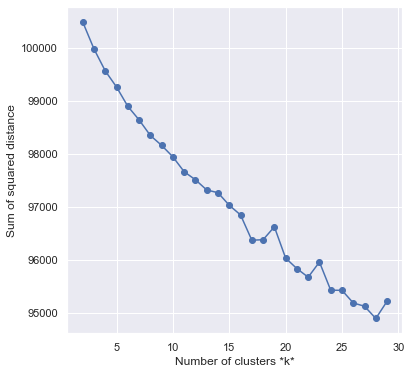

In [16]:
sse = []
list_k = list(range(2, 30))

for k in list_k:
    km = KMeans(n_clusters=k)
    km.fit(X_reduced)
    sse.append(km.inertia_)

# Plot sse against k
plt.figure(figsize=(6, 6))
plt.plot(list_k, sse, '-o')
plt.xlabel(r'Number of clusters *k*')
plt.ylabel('Sum of squared distance')

In [17]:
from sklearn import metrics
from scipy.spatial.distance import cdist

# run kmeans with many different k
distance = []
K = range(2, 32)
for k in K:
    k_means = KMeans(n_clusters=k, random_state=42)
    k_means.fit(X_reduced)
    distance.append(sum(np.min(cdist(X_reduced, k_means.cluster_centers_, 'euclidean'), axis=1)) / X.shape[0])

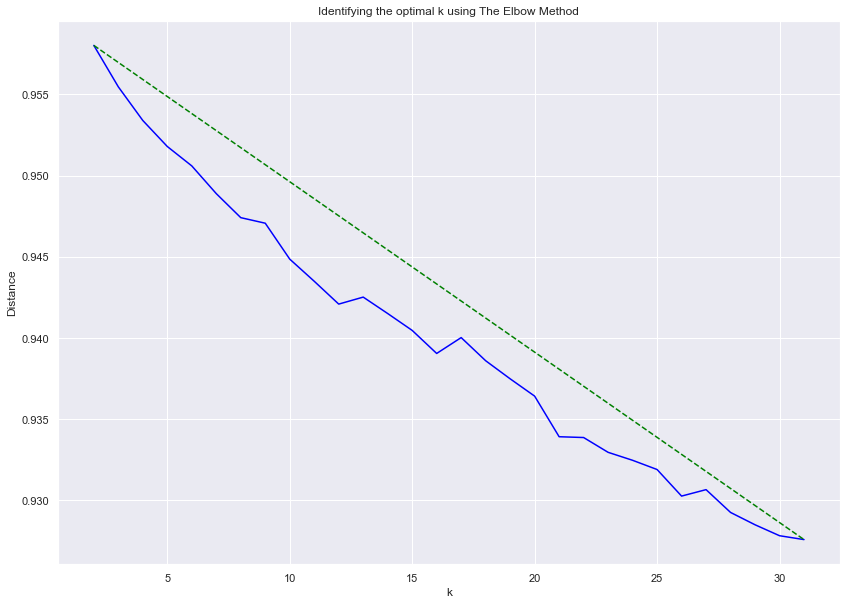

In [18]:
X_line = [K[0], K[-1]]
Y_line = [distance[0], distance[-1]]

plt.plot(K, distance, color='blue')
plt.plot(X_line, Y_line, color='green', linestyle='dashed')
plt.xlabel('k')
plt.ylabel('Distance')
plt.title('Identifying the optimal k using The Elbow Method')
plt.show()

In [33]:
k = 12
kmeans = KMeans(n_clusters=k, random_state=42, n_jobs=-1)
y_pred = kmeans.fit_predict(X_reduced)
trunc_df['y'] = y_pred

C:\Users\kre8tions\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:938: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"


In [35]:
centers = np.array(kmeans.cluster_centers_)

### Plotting our Results

#### PCA

C:\Users\kre8tions\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


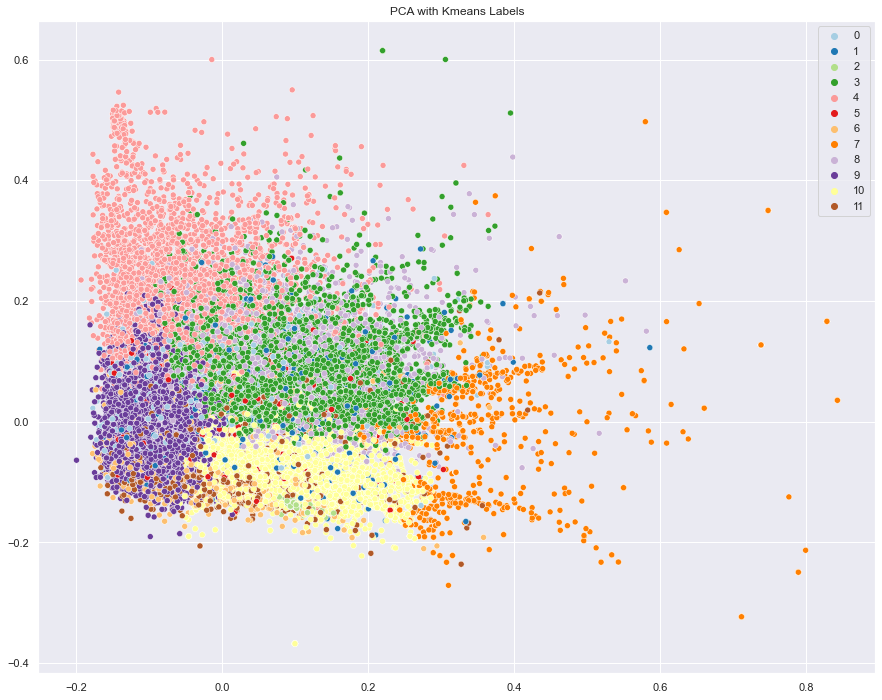

In [37]:
# sns settings
sns.set(rc={'figure.figsize':(15, 12)})

# plot
sns.scatterplot(X_reduced[:,0], X_reduced[:,1], hue=y_pred, legend='full', palette='Paired')
sns.color_palette()
plt.title('PCA with Kmeans Labels')
plt.show()


### Evaluating our model

In [65]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, recall_score, mean_squared_error
import math

In [45]:
from sklearn.model_selection import train_test_split

# test set size of 20% of the data
X_train, X_test, y_train, y_test = train_test_split(X.toarray(),y_pred, test_size=0.2, random_state=42)

In [47]:
# Fit a basic Random Forest model
rf = RandomForestClassifier()
rf_model = rf.fit(X_train, y_train)

In [48]:
# Make predictions on the test set using the fit model
y_pred = rf_model.predict(X_test)

In [73]:
# Evalute model predictions using precision and recall
precision = precision_score(y_test, y_pred, average='micro')
recall = recall_score(y_test, y_pred, average='micro')
mse = mean_squared_error(y_test, y_pred)
accuracy = math.sqrt(mse)
print('Precision: {}'.format(round(precision, 3)))
print('Recall: {}'.format(round(recall, 3)))
print('Accuracy: {}'.format(round(max(0,accuracy), 3)))

Precision: 0.95
Recall: 0.95
Accuracy: 0.987


In [40]:
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer

In [41]:
vectorizers = []
    
for cluster in range(0, 12):
    # Creating a vectorizer
    vectorizers.append(CountVectorizer(min_df=10, max_df=0.90, ngram_range=(1, 4), 
                                       stop_words='english', lowercase=True, 
                                       token_pattern='[a-zA-Z\-][a-zA-Z\-]{2,}'))

In [42]:
vectorized_data = []

for current_cluster, cvec in enumerate(vectorizers):
    try:
        vectorized_data.append(cvec.fit_transform(trunc_df.loc[trunc_df['y'] == current_cluster, 'processed_text']))
    except Exception as e:
        print(f"Not enough in cluster: {current_cluster}")
        vectorized_data.append(None)

In [43]:
len(vectorized_data)

12

In [50]:
# number of topics per cluster
TOPICS_PER_CLUSTER = 30

lda_models = []
for cluster in range(0, 12):
    # Latent Dirichlet Allocation Model
    lda = LatentDirichletAllocation(n_components=TOPICS_PER_CLUSTER, max_iter=10, learning_method='online',
                                    verbose=False, random_state=42)
    lda_models.append(lda)
    

LatentDirichletAllocation(learning_method='online', n_components=30,
                          random_state=42, verbose=False)

In [51]:
clusters_lda_data = []

for current_cluster, lda in enumerate(lda_models):
    # print("Current Cluster: " + str(current_cluster))
    
    if vectorized_data[current_cluster] != None:
        clusters_lda_data.append((lda.fit_transform(vectorized_data[current_cluster])))

### Finding Important Topic Keywords

In [52]:
def selected_topics(model, vectorizer, top_n=3):
    current_words = []
    keywords = []
    elim_words = ['http', 'coronavirus covid https','coronavirus covid','covid coronavirus', 'coronavirus https', 'covid https',
                  'coronavirusupdate', 'coronaviruslockdown', 'coronavirusupdates', 'coronavirususa', 'covid', 'pandemic', 
                  'virus', 'corona', 'coronaviruspandemic', 'stayathomeandstaysafe', 'live', 'coronavirus', 'https', 
                  'covid-', 'coronaupdate', 'need', 'socialdistanacing', 'coronavirusoutbreak', 'coronavirus crisis https', 
                  'covid covid']
    
    for idx, topic in enumerate(model.components_):
        words = [(vectorizer.get_feature_names()[i], topic[i]) for i in topic.argsort()[:-top_n - 1:-1]]
        for word in words:
            if word[0] not in current_words and word[0] not in elim_words:
                keywords.append(word)
                current_words.append(word[0])
                
    keywords.sort(key = lambda x: x[1])  
    keywords.reverse()
    return_values = []
    for ii in keywords:
        return_values.append(ii[0])
    return return_values

In [53]:
all_keywords = []
for current_vectorizer, lda in enumerate(lda_models):
    # print("Current Cluster: " + str(current_vectorizer))

    if vectorized_data[current_vectorizer] != None:
        all_keywords.append(selected_topics(lda, vectorizers[current_vectorizer]))

In [56]:
for topic in range(12):
    print(f'  Topic {topic}: Top 50 words')
    print(all_keywords[topic][:50])
    print(" ")

  Topic 0: Top 50 words
['president', 'amp', 'like', 'american', 'usa', 'china', 'disinfectant', 'gop', 'want', 'death', 'administration', 'new', 'america', 'covid trump', 'good', 'let', 'cnn', 'kill', 'right', 'country', 'health', 'trump administration', 'house', 'case', 'blame', 'maga', 'white', 'drug', 'biden', 'covid pandemic', 'plan', 'watch', 'order', 'white house', 'trumpvirus', 'people', 'use', 'tell', 'medical', 'war', 'open', 'election', 'donaldtrump', 'read', 'kag', 'long', 'obama', 'threat', 'act', 'early']
 
  Topic 1: Top 50 words
['covid lockdown', 'day', 'coronavirus lockdown', 'time', 'new', 'stayhome', 'today', 'staysafe', 'extend', 'end', 'world', 'video', 'spread', 'know', 'social', 'stayathome', 'country', 'case', 'police', 'use', 'april', 'lift', 'china', 'amp', 'start', 'free', 'government', 'test', 'measure', 'distance', 'check', 'feel', 'business', 'quarantinelife', 'youtube', 'online', 'order', 'try', 'stop', 'govt', 'week', 'report', 'face', 'friend', 'period